In [ ]:
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
!pip install optax
!git clone https://github.com/MarcoForte/closed-form-matting.git
import os
os.chdir('closed-form-matting')
!pip3 install .
os.chdir('..')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-m5pyp5cz
  Running command git clone -q https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-m5pyp5cz
     |████████████████████████████████| 189 kB 30.5 MB/s 
     |████████████████████████████████| 154 kB 38.8 MB/s 
     |████████████████████████████████| 237 kB 67.0 MB/s 
     |████████████████████████████████| 8.3 MB 66.4 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 
  Created wheel for flaxmodels: filename=flaxmodels-0.1.2-py3-none-any.whl size=115737 sha256=6346ee0a377e400dd6fb0ba058c42c3b6cfb847c483448b9d82c562c56fbdd06
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2yc8bap/wheels/b1/16/4e/6e7f5aa6a1c912db017f34a3bdf96761478b3cfdb907009951
Successfully built flaxmodels
Looking in indexes: https://pypi.org/simpl

In [ ]:
from PIL import Image
import jax
import jax.numpy as jnp
import flaxmodels as fm
import matplotlib.pyplot as plt
from jax import jit, random, grad
import numpy as np
import optax
from functools import partial
from tqdm import trange
from jax.example_libraries import optimizers
from closed_form_matting import compute_laplacian

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  8 04:59:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |  13610MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2022-12-08 04:59:57--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.002s  

2022-12-08 04:59:57 (65.2 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2022-12-08 04:59:58--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0s      

2022-12-08 04:59:58 (144 MB/s) 

# Load your image

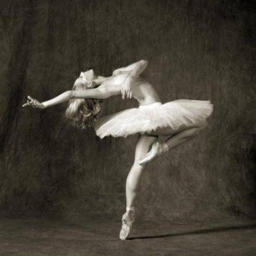

In [ ]:
# Load image
img_con = Image.open('dancing.jpg').resize((256,256))
display(img_con)

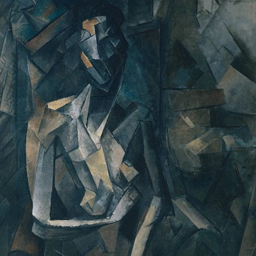

In [ ]:
img_sty = Image.open('picasso.jpg').resize((256,256))
display(img_sty)

In [ ]:
# Image should be in range [0, 1]
image_content = jnp.array(img_con, dtype=jnp.float32) / 255.0

# Add batch dimension
img_content = jnp.expand_dims(image_content, axis=0)

In [ ]:
image_style = jnp.array(img_sty, dtype=jnp.float32) / 255

img_style = jnp.expand_dims(image_style, axis=0)

In [ ]:
class StyleTransfer:
  def __init__(self, input_content, input_style, content_layers, style_layers):
    # Original style and content input
    self.origin_content = input_content
    self.origin_style = input_style

    # Initialize Pretrained model
    self.vgg19 = fm.VGG19(output='activations', pretrained='imagenet', include_head=False)
    self.init_rngs = {'params': jax.random.PRNGKey(0)}#, 'dropout': jax.random.PRNGKey(1)}
    self.vggparams = self.vgg19.init(self.init_rngs, img_content)
    self.fn_out = jit(self.vgg19.apply)

    # Get VGG activation of original style and content input
    self.activation_style_origin = self.fn_out(self.vggparams, self.origin_style, train=False)
    self.activation_content_origin = self.fn_out(self.vggparams, self.origin_content, train=False)

    # Initialize style layer and content layer
    self.layer_style = style_layers
    self.layer_content = content_layers

    #Initialize style and content weights
    self.style_weight = 100000
    self.content_weight = 1

    # Initialize Optimizer
    self.lr = 1e-3
    self.optimizer = optax.adam(learning_rate = self.lr)

    # Initialize generated image
    self.generate_img = self.origin_content#jax.random.normal(jax.random.PRNGKey(0), self.origin_content.shape)
    self.opt_state = self.optimizer.init(self.generate_img)

  @partial(jit, static_argnums=(0,))
  def gram_matrix(self, input):
    input = jnp.transpose(input, axes=(0, 3, 1, 2))
    a, b, c, d = input.shape #a=1, batchsize, b=3 number of feature maps, (c,d) size of feature map
    features = input.reshape(a * b, c * d)
    G = jnp.matmul(features, features.T)
    return G / (a * b * c * d)

  @partial(jit, static_argnums=(0,))
  def content_loss(self, input_content, img_generated):
    diff = jnp.abs(img_generated-input_content)
    smoo_l1 = jnp.where(diff<1, 0.5*diff**2, diff-0.5)
    return jnp.mean(smoo_l1)#jnp.mean((input_content.flatten()-img_generated.flatten()) ** 2)
  
  @partial(jit, static_argnums=(0,))
  def style_loss(self, input_style, img_generated):
    diff = jnp.abs(img_generated-input_style)
    smoo_l1 = jnp.where(diff<1, 0.5*diff**2, diff-0.5)
    return jnp.mean(smoo_l1)#jnp.mean((input_style - img_generated) ** 2)

  @partial(jit, static_argnums=(0,))
  def loss(self, img_generated):
    out_generated = self.fn_out(self.vggparams, img_generated, train=False)
    
    style_score = 0
    content_score = 0

    for cont_layer in self.layer_content:
      content_score += self.content_loss(self.activation_content_origin[cont_layer], out_generated[cont_layer])
    
    for sty_layer in self.layer_style:
      gram_sty = self.gram_matrix(self.activation_style_origin[sty_layer])
      gram_gen = self.gram_matrix(out_generated[sty_layer])
      style_score += self.style_loss(gram_sty, gram_gen)
    
    loss = self.style_weight * style_score + self.content_weight * content_score
    return loss
  
  @partial(jit, static_argnums=(0,))
  def step(self, optimizer_state, img_generated):
    grads = grad(self.loss)(img_generated)
    updates, opt_state = self.optimizer.update(grads, optimizer_state, img_generated)
    return optax.apply_updates(img_generated, updates), opt_state

  def train(self, iter = 2000):
    for iter in trange(iter):
      self.generate_img, self.opt_state = self.step(self.opt_state, self.generate_img)
      self.generate_img = jnp.clip(self.generate_img, 0, 1)
    
    return self.generate_img




In [ ]:
content_layers_default = ['conv4_2']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
sty_trans = StyleTransfer(img_content, img_style, content_layers_default, style_layers_default)

In [ ]:
output = sty_trans.train()

100%|██████████| 2000/2000 [01:42<00:00, 19.42it/s]


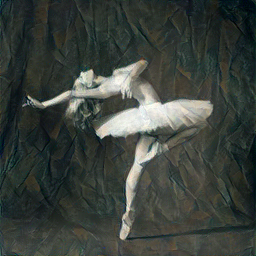

In [ ]:
img_output = np.array(output[0]*255).astype('uint8')
img_out = Image.fromarray(img_output)
display(img_out)
Image.Image.save(img_out, fp='SmoothL1loss.jpg')